In [4]:
# this will make things a bit slower, but hopefully make debugging easier
%load_ext autoreload
%autoreload 2

# disable CUDA for TF
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# stdlib & generic third-party imports
import joblib
import json
import re
import numpy as np
import seaborn as sns
import subprocess
import pandas as pd
import shutil
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)

# 
import glob, multiprocessing
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML,Image

# multiple_irl stuff
import multiple_irl.envs.rooms as rooms
import multiple_irl.envs
import multiple_irl.models.architectures as archs
import multiple_irl.models.shaped_airl as shaped_airl
from multiple_irl.models.shaped_airl import AIRL
from inverse_rl.models.imitation_learning import GAIL
from inverse_rl.utils.log_utils import load_latest_experts

# stuff from rllab etc.
from rllab.sampler.utils import rollout
import tensorflow as tf

# logging stuff
import rllab.misc.logger as rllab_logger
from gym import logger as gym_logger
rllab_logger.set_log_tabular_only(True)
# why doesn't this work?! Should shut up Gym permanently
gym_logger.set_level(50)

# this lets Jupyter display FuncAnimations directly
rc('animation', html='html5')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Various Rooms

Text(0.5,1,'Two Room')

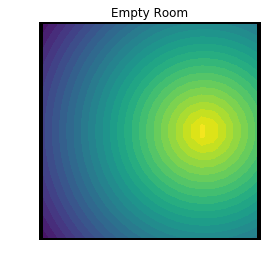

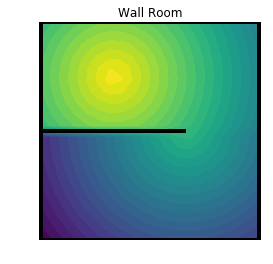

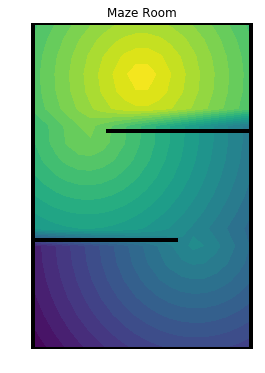

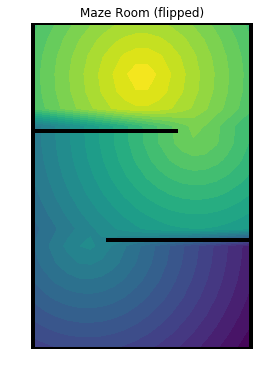

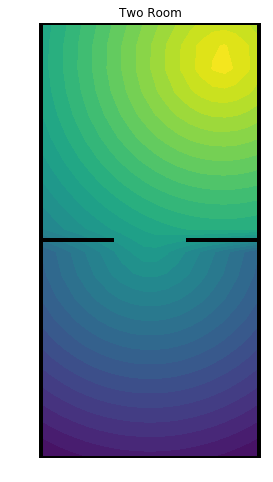

In [2]:
plt.figure(figsize=(4,4))
r = rooms.EmptyRoom()
r.draw()
r.draw_reward()
plt.axis('equal')
plt.axis('off')
plt.title('Empty Room')

plt.figure(figsize=(4,4))
r = rooms.RoomWithWall()
r.draw()
r.draw_reward()
plt.axis('equal')
plt.axis('off')
plt.title('Wall Room')

plt.figure(figsize=(4,6))
r = rooms.MazeRoom()
r.draw()
r.draw_reward()
plt.axis('equal')
plt.axis('off')
plt.title('Maze Room')

plt.figure(figsize=(4,6))
r = rooms.MazeRoom(flip=True)
r.draw()
r.draw_reward()
plt.axis('equal')
plt.axis('off')
plt.title('Maze Room (flipped)')

plt.figure(figsize=(4,8))
r = rooms.TwoRoom()
r.draw()
r.draw_reward()
plt.axis('equal')
plt.axis('off')
plt.title('Two Room')

## Testing AIRL on maze environments

I want to find an environment where the AIRL-recovered reward is *not* reoptimisable. Judging by the plots Sergey showed me, the following rooms show some promise:

1. Maze room
2. Two room
3. /Possibly/ wall room if the wall side is switched between discriminator-training and policy-reoptimisation. Apparently this posed few issues in the paper, but Sergey's plots suggested that was fragile or something.

# Code copied from `Scratch.ipynb`

In [5]:
def get_inner_env(env):
    if hasattr(env, 'wrapped_env'):
        return get_inner_env(env.wrapped_env)
    elif hasattr(env, 'env'):
        return get_inner_env(env.env)
    return env

def viz_single_policy(fname, n=5):
    tf.reset_default_graph()
    with tf.Session(graph=tf.Graph()) as sess:
        data = joblib.load(fname)
        
        #for i in range(4):
        #    env = data[str(i)]['env']
        #    policy = data[str(i)]['policy']
        env = data['env']

        policy = data['policy']
        plt.figure()
        
        inner_env = get_inner_env(env)
        inner_env.room.draw_reward()
        inner_env.room.draw()
        for i in range(n):
            path = rollout(env, policy, max_path_length=30)
            plt.scatter(*path['observations'][:,:2].T, alpha=0.1)
            
    plt.axis('equal')
        
    tf.reset_default_graph()

def final_dist(path):
    return path['env_infos']['distance'][-1]

def avg_statistic(fname, f=final_dist, n=5):
    tf.reset_default_graph()
    with tf.Session(graph=tf.Graph()) as sess:
        data = joblib.load(fname)
        
        #for i in range(4):
        #    env = data[str(i)]['env']
        #    policy = data[str(i)]['policy']
        env = data['env']

        policy = data['policy']
        env.wrapped_env.env.start_anywhere = False
        stats = []
        for i in range(n):
            path = rollout(env, policy, max_path_length=100)
            stats.append(f(path))
        
    tf.reset_default_graph()
    return np.mean(stats)

def wrap_around_irl(irl_model):
    def f(x,y):
        obs = np.array([[x,y,0]])
        # reward = irl_model.debug_eval(obs)['value'][0]
        reward = irl_model.debug_eval(obs, acts=np.zeros((1, 2)))['reward'][0]
        
        return reward
    return f

def infer_method(pkl_path):
    pkl_dir = os.path.dirname(os.path.abspath(pkl_path))
    param_path = os.path.join(pkl_dir, 'params.json')
    with open(param_path, 'r') as fp:
        json_data = json.load(fp)
    irl_cls = json_data['irl_model']['__clsname__']
    if irl_cls == 'AIRL':
        if json_data['irl_model']['vairl']:
            return 'vairl'
        return 'airl'
    elif irl_cls == 'GAIL':
        if json_data['irl_model']['vail']:
            return 'vail'
        return 'gail'
    raise NotImplementedError(
        "I don't know how to deal with IRL class %s for %s :(" %
        (irl_cls, pkl_path))
    
def _load_irl_model(env, fname, loaded_pkl, model_kwargs):
    method = infer_method(fname)
    kwargs = dict(model_kwargs)
    if method in {'airl', 'vairl'}:
        kwargs.setdefault('vairl', method == 'vairl')
        irl_model = AIRL(
            env=env,
            state_only=True,
            freeze=True,
            vairl_beta=1e-4,
            **kwargs)
    elif method in {'gail', 'vail'}:
        irl_model = GAIL(
            env,
            name=method,
            freeze=True,
            vail=method == 'vail',
            **kwargs)
    else:
        raise Exception('idk how to handle %s' % (method, ))
    irl_model.set_params(loaded_pkl['irl_params'])
    return irl_model

def _draw_room(env, *, xy_to_energy=None, hide_rew=False, hide_cbar=True):
    inner_env = get_inner_env(env)
    ax = plt.gca()
    if hasattr(inner_env, 'room'):
        if not hide_rew:
            mapping = inner_env.room.draw_reward(xy_to_energy, ax)
            if not hide_cbar:
                plt.colorbar(mapping)
        inner_env.room.draw(ax)
    elif hasattr(inner_env, 'draw'):
        if not hide_rew:
            mapping = inner_env.draw_reward(xy_to_energy, ax)
            if not hide_cbar:
                plt.colorbar(mapping)
        inner_env.draw(ax)
    elif inner_env.__class__.__name__ == 'PointMazeEnv':
        import inverse_rl.envs.point_maze_env as pme
        if not hide_rew:
            mapping = pme.PointMazeEnv.draw_reward(inner_env, xy_to_energy, ax)
            if not hide_cbar:
                plt.colorbar(mapping)
        pme.PointMazeEnv.draw(inner_env, ax)
    else:
        print("Don't know how to draw reward for %s :(" % (inner_env, ))

def viz_reward(fname, n=1, figsize=None, fig=None, equal=True, det=None,
               hide_cbar=False, hide_rew=False, **kwargs):
    tf.reset_default_graph()
    with tf.Session(graph=tf.Graph()) as sess:
        # load data from pickle
        data = joblib.load(fname)
        env = data['env']
        policy = data['policy']
        
        # set up figure
        if fig is None:
            plt.figure(figsize=figsize)
        ax = plt.gca()
        
        # set up IRL model
        irl_model =  _load_irl_model(env, fname, data, kwargs)
        
        # draw reward surface and room
        xy_to_energy = wrap_around_irl(irl_model)
        _draw_room(env, xy_to_energy=xy_to_energy, hide_rew=hide_rew,
                   hide_cbar=hide_cbar)

        # plot some trajectories
        # setting start_anywhere attribute does nothing for Justin's
        # pointmaze environments
        env.wrapped_env.env.start_anywhere = False
        for i in range(n):
            path = rollout(env, policy, det=det, max_path_length=100)
            plt.scatter(*path['observations'][:,:2].T,s=12)
            
        # make the plot aspect ratio equal
        if equal:
            plt.axis('equal')

    tf.reset_default_graph()

def plot_reward_profile(fname, n=5, figsize=None, fig=None, label=None, **kwargs):
    tf.reset_default_graph()
    with tf.Session(graph=tf.Graph()) as sess:
        data = joblib.load(fname)
        
        env = data['env']

        policy = data['policy']
        if fig is None:
            plt.figure(figsize=figsize)
        ax = plt.gca()
        irl_model = shaped_airl.AIRL(
            env=env, expert_trajs=None, fusion=True, state_only=True,
            freeze=True, **kwargs)
        irl_model.set_params(data['irl_params'])

        env.wrapped_env.env.start_anywhere = False
        all_x = []
        all_y = []
        for i in range(n):
            path = rollout(env, policy, max_path_length=100)  # , deterministic=True)
            rew_vec = path['rewards']
            all_x.extend(range(len(rew_vec)))
            all_y.extend(rew_vec)
            
        sns.lineplot(x=all_x, y=all_y, label=label)

    tf.reset_default_graph()

def load_pkl(pkl_path):
    # can use this to pull out actual data in snapshots
    with tf.Session(graph=tf.Graph()) as sess:
        with open(pkl_path, 'rb') as fp:
            data = joblib.load(fp)
        return data
    
def viz_experts(dirname, npaths=5, alpha=0.1, fig=None, hide_rew=False):
    # first load expert trajectories
    experts = load_latest_experts(dirname)
    
    # now load environment from pickle
    random_pkl = sorted(glob.glob(os.path.join(dirname, 'itr_*.pkl')))[-1]
    data = load_pkl(random_pkl)
    env = data['env']
        
    # finally plot things
    if fig is None:
        plt.figure()
    inner_env = get_inner_env(env)
    ax = plt.gca()
    if hasattr(inner_env, 'room'):
        if not hide_rew:
            inner_env.room.draw_reward()
        inner_env.room.draw()
    elif hasattr(inner_env, 'draw'):
        if not hide_rew:
            mapping = inner_env.draw_reward(ax=ax)
            plt.colorbar(mapping)
        inner_env.draw(ax)
    elif inner_env.__class__.__name__ == 'PointMazeEnv':
        import inverse_rl.envs.point_maze_env as pme
        if not hide_rew:
            mapping = pme.PointMazeEnv.draw_reward(inner_env, ax=ax)
            plt.colorbar(mapping)
        pme.PointMazeEnv.draw(inner_env, ax)
    
    # experts are pre-shuffled so this should show us different paths each time
    for path in experts[:npaths]:
        plt.scatter(*path['observations'][:,:2].T, alpha=alpha)
            
    plt.axis('equal')

In [ ]:
expts = load_latest_experts('../data/env_pointmazeright-v0/', n=5)
expts = load_latest_experts('../data/env_shaped_pm_mazeroom_small-v0/', n=5)

# Displaying trajectories & environments

In [ ]:
import re

def plot_runs_row(title, pkl_pattern):
    files = glob.glob(pkl_pattern)
    assert len(files) > 0, "nothing in '%s'" % (pkl_pattern, )
    ncols = len(files)
    height = 2 if 'C-maze' in title else 3
    fig = plt.figure(figsize=(8, height))
    is_vairl = '_vairl' in pkl_pattern
    for col, fpath in enumerate(files, start=1):
        plt.subplot(1, ncols, col)
        plt.axis('off')
        viz_reward(fpath, n=5, fig=fig, hide_cbar=True)
    plt.suptitle(title)
    plt.tight_layout()
    dest_dir = os.path.expanduser('~/vairl/figs/flips/')
    os.makedirs(dest_dir, exist_ok=True)
    out_fn = re.sub(r'\W+', '-', title).lower() + '.pdf'
    out_path = os.path.join(dest_dir, out_fn)
    print('Writing to %s' % (out_path, ))
    plt.savefig(out_path)

plot_runs_row(r'VAIRL C-maze ($\beta=0$)', '../data/env_pointmazeright-v0_vairl/2018_09_26_09_34_36_*/retrain_pointmazeleft-v0/itr_199.pkl')
# C-maze with 0.5 target (S-maze with 0.05 instead)
plot_runs_row(r'VAIRL C-maze', '../data/env_pointmazeright-v0_vairl/2018_09_26_09_37_10_*/retrain_pointmazeleft-v0/itr_199.pkl')
plot_runs_row(r'AIRL C-maze', '../data/env_pointmazeright-v0_airl/2018_09_26_09_40_06_*/retrain_pointmazeleft-v0/itr_199.pkl')
plot_runs_row(r'VAIL C-maze', '../data/env_pointmazeright-v0_vail/2018_09_26_09_37_54_*/retrain_pointmazeleft-v0/itr_199.pkl')
plot_runs_row(r'GAIL C-maze', '../data/env_pointmazeright-v0_gail/2018_09_26_09_40_18_*/retrain_pointmazeleft-v0/itr_199.pkl')
# also original imitation runs:
plot_runs_row(r'Original VAIRL C-maze ($\beta=0$)', '../data/env_pointmazeright-v0_vairl/2018_09_26_09_34_36_*/itr_199.pkl')
plot_runs_row(r'Original VAIRL C-maze', '../data/env_pointmazeright-v0_vairl/2018_09_26_09_37_10_*/itr_199.pkl')
plot_runs_row(r'Original AIRL C-maze', '../data/env_pointmazeright-v0_airl/2018_09_26_09_40_06_*/itr_199.pkl')
plot_runs_row(r'Original VAIL C-maze', '../data/env_pointmazeright-v0_vail/2018_09_26_09_37_54_*/itr_199.pkl')
plot_runs_row(r'Original GAIL C-maze', '../data/env_pointmazeright-v0_gail/2018_09_26_09_40_18_*/itr_199.pkl')

plot_runs_row(r'VAIRL S-maze ($\beta=0$)', '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_22_58_23_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
# S-maze with 0.05
plot_runs_row(r'VAIRL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_15_06_58_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
plot_runs_row(r'AIRL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_airl/2018_09_25_22_58_22_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
plot_runs_row(r'VAIL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_vail/2018_09_25_22_56_11_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
plot_runs_row(r'GAIL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_gail/2018_09_25_22_57_42_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
# original imitation runs:
plot_runs_row(r'Original VAIRL S-maze ($\beta=0$)', '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_22_58_23_*/itr_199.pkl')
# S-maze with 0.05
plot_runs_row(r'Original VAIRL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_15_06_58_*/itr_199.pkl')
plot_runs_row(r'Original AIRL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_airl/2018_09_25_22_58_22_*/itr_199.pkl')
plot_runs_row(r'Original VAIL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_vail/2018_09_25_22_56_11_*/itr_199.pkl')
plot_runs_row(r'Original GAIL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_gail/2018_09_25_22_57_42_*/itr_199.pkl')

In [ ]:
# what do expert demonstrations look like
fig = plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
viz_experts('../data/env_shaped_pm_mazeroom_small-v0/', npaths=0, fig=fig)
plt.subplot(2, 2, 2)
viz_experts('../data/env_shaped_pm_mazeroom_flip_small-v0/', npaths=0, fig=fig)
plt.subplot(2, 2, 3)
viz_experts('../data/env_pointmazeright-v0/', npaths=0, fig=fig)
plt.subplot(2, 2, 4)
viz_experts('../data/env_pointmazeleft-v0/', npaths=0, fig=fig)
plt.savefig('/home/sam/etc/vairl/figs/gt-mazes.pdf')
plt.show()

In [ ]:
# now vis (1) expert, (2) recovered reward, and (3) re-optimised reward
# print('Original reward; expert policy')
# viz_single_policy('../data/maze_shaped_pm_mazeroom_small-v0/itr_199.pkl')
# print('Original reward; AIRL policy')
# viz_single_policy('../data/maze_shaped_pm_mazeroom_small-v0_airl_fusion/2018_09_04_02_49_12_0/itr_199.pkl')
# print('Original reward; retrained AIRL policy')
# viz_single_policy('../data/maze_shaped_pm_mazeroom_small-v0_airl_fusion/2018_09_04_02_49_12_0/retrain/itr_199.pkl')

# viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_airl_fusion/2018_09_04_02_49_12_4/itr_199.pkl', n=5)
# plt.title('AIRL reward; AIRL policy')

# viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_airl_fusion/2018_09_04_02_49_12_4/retrain/itr_199.pkl')
# plt.title('AIRL reward; retrained policy')

# viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_04_05_28_40_1/itr_199.pkl', n=5, vairl=True)
# plt.title('VAIRL reward; VAIRL policy')

# viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_04_05_28_40_1/retrain/itr_199.pkl', vairl=True)
# plt.title('VAIRL reward; retrained policy')

# viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion_smallbeta/2018_09_04_15_55_57_3/itr_199.pkl', n=5, vairl=True)
# plt.title('VAIRL reward; VAIRL policy')

# viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion_smallbeta/2018_09_04_15_55_57_3/retrain/itr_199.pkl', vairl=True)
# plt.title('VAIRL reward; retrained policy')

for i in range(5):
    # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_01_24_19_%d/itr_199.pkl' % i, n=5, vairl=True)
    # plt.title('VAIRL reward; VAIRL policy')
    ex_frames = list(range(0, 200))
    fig = plt.figure()
    def draw_frame(idx=0):
        j = ex_frames[idx]
        plt.clf()
        # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_02_52_36_%d/itr_%d.pkl' % (i, j),
        #            fig=fig, n=10, vairl=True)
        # plt.title('VAIRL reward; original VAIRL policy')
        viz_reward(
            '../data/maze_shaped_pm_mazeroom_small-v0_airl_fusion/2018_09_06_16_45_26_%d/retrain/itr_%d.pkl' % (i, j),
            fig=fig, n=10, vairl=False)
        plt.title('AIRL reward; retrained AIRL policy')
    # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_02_52_36_%d/retrain/itr_19(7.pkl' % i, n=5, vairl=True)
    # plt.title('VAIRL reward; retrained VAIRL policy'))
    # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_02_52_36_%d/retrain/itr_198.pkl' % i, n=5, vairl=True)
    # plt.title('VAIRL reward; retrained VAIRL policy')
    # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_02_52_36_%d/retrain/itr_199.pkl' % i, n=5, vairl=True)
    # plt.title('VAIRL reward; retrained VAIRL policy')
    ani = animation.FuncAnimation(
        fig, draw_frame, init_func=draw_frame, interval=100, blit=False, save_count=50, frames=len(ex_frames))
    save_path = '/tmp/airl-retrain-%d.mp4' % i
    ani.save(save_path, writer='ffmpeg', fps=5)
    # Image(save_path)

In [ ]:
# fig = plt.figure(figsize=(3, 3))
# plt.axis('off')
# viz_reward(
#     '../data/env_shaped_pm_mazeroom_small-v0_airl/2018_09_21_10_21_17_3/retrain/itr_199.pkl',
#     n=5, vairl=False, fig=fig, equal=False)
# plt.gca().set_aspect(1/2)
# plt.savefig('/home/sam/airl.pdf')

fig = plt.figure(figsize=(3, 3))
plt.axis('off')
viz_reward(
    # '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_19_17_37_23_2/retrain/itr_199.pkl',
    '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_15_06_58_0/retrain_shaped_pm_mazeroom_flip_small-v0/itr_300.pkl',
    n=5, vairl=True, fig=fig, det=True, equal=False)
plt.gca().set_aspect(1/2)
# plt.savefig('/home/sam/vairl.pdf')

In [ ]:
def do_work(pfx='../data/maze_shaped_pm_mazeroom_small-v0_airl_fusion/2018_09_06_16_45_26_0/', retrain=False, n_itrs=200):
    if retrain:
        retrain_pfx = 'retrain/'
        retrain_str = 'retrain-'
    else:
        retrain_pfx = ''
        retrain_str = ''
    ex_frames = list(range(0, n_itrs))
    fig = plt.figure()
    def draw_frame(idx=0):
        j = ex_frames[idx]
        plt.clf()
        # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_02_52_36_%d/itr_%d.pkl' % (i, j),
        #            fig=fig, n=10, vairl=True)
        # plt.title('VAIRL reward; original VAIRL policy')
        viz_reward(os.path.join(pfx, '%sitr_%d.pkl' % (retrain_pfx, j)),
                   fig=fig, n=10, vairl=True)
        plt.title('VAIRL reward & %spolicy' % retrain_str)
    # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_02_52_36_%d/retrain/itr_19(7.pkl' % i, n=5, vairl=True)
    # plt.title('VAIRL reward; retrained VAIRL policy'))
    # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_02_52_36_%d/retrain/itr_198.pkl' % i, n=5, vairl=True)
    # plt.title('VAIRL reward; retrained VAIRL policy')
    # viz_reward('../data/maze_shaped_pm_mazeroom_small-v0_vairl_fusion/2018_09_05_02_52_36_%d/retrain/itr_199.pkl' % i, n=5, vairl=True)
    # plt.title('VAIRL reward; retrained VAIRL policy')
    ani = animation.FuncAnimation(
        fig, draw_frame, init_func=draw_frame, interval=100, blit=False, save_count=50, frames=len(ex_frames))
    save_path = '/tmp/vid-%s-%s.mp4' % (pfx.replace('/', '-').replace('.', '-'), retrain_str)
    ani.save(save_path, writer='ffmpeg', fps=5)
    
def do_work_wrapper(args):
    return do_work(*args)
    
# all_args = []
# for beta in [0, 0.001, 0.1, 1, 10]:
#     pfxes = glob.glob('../data/maze_shaped_pm_mazeroom_small-v0_vairl_beta%g_fusion/2018_*/' % beta)
#     assert len(pfxes) > 1
#     for pfx in pfxes:
#         for retrain in [True, False]:
#             all_args.append((pfx, retrain))
#             
# # wanted to do this with MP, but it keeps hanging :(
# list(map(do_work_wrapper, all_args))

fig = plt.figure(figsize=(6, 6))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    retrain_s = 'retrain_shaped_pm_mazeroom_flip_small-v0'
    viz_reward(
        '../data/env_shaped_pm_mazeroom_small-v0_airl/2018_09_25_22_58_22_%d/%s/itr_399.pkl' % (i, retrain_s),
        n=5, vairl=False, fig=fig)
    plt.suptitle('AIRL %s' % (retrain_s,))
plt.show()
# !mkdir -p ~/figs/
# plt.savefig(os.path.expanduser('~/figs/airl.pdf'))

for kl, dates in [
    # (0.5, '2018_09_26_09_01_18_'),
    # ('fixed beta', '2018_09_19_20_56_27_'),
    (0.05, '2018_09_25_15_06_58_'),
    # (5.0, '2018_09_20_13_47_34_')
]:
    for retrain_s in [
        # '',
        # 'retrain',
        'retrain_shaped_pm_mazeroom_flip_small-v0',
    ]:
        fig = plt.figure(figsize=(6, 6))
        for i in range(5):
            plt.subplot(2, 3, i+1)
            plt.axis('off')
            viz_reward(
               '../data/env_shaped_pm_mazeroom_small-v0_vairl/%s%d/%s/itr_399.pkl' % (dates, i, retrain_s),
                n=5, vairl=True, fig=fig)
            plt.suptitle('VAIRL, target KL=%s %s' % (kl, retrain_s))
        plt.show()
        # plt.savefig(os.path.expanduser('~/figs/vairl-kl-%s-%s%s.pdf' % (kl, dates, retrain_s)))
        
        # fig = plt.figure(figsize=(6, 6))
        # for i in range(5):
        #     plt.subplot(2, 3, i+1)
        #     plt.axis('off')
        #     viz_reward(
        #        '../data/env_shaped_pm_mazeroom_small-v0_vairl/%s%d/%s/itr_199.pkl' % (dates, i, retrain_s),
        #         n=5, vairl=True, fig=fig)
        #     plt.suptitle('experts')
        # plt.show()
        # plt.savefig(os.path.expanduser('~/figs/experts.pdf'))

In [ ]:
fig = plt.figure(figsize=(2, 2))
viz_reward(
    '../data/env_pointmazeright-v0_airl/2018_09_26_09_40_06_3/itr_199.pkl',
    n=5, vairl=False, fig=fig)
plt.title('AIRL, original environment')
plt.axis('off')
!mkdir -p ~/etc/vairl/figs/
plt.savefig(os.path.expanduser('~/etc/vairl/figs/airl-crap-cmaze-orig.pdf'))
plt.show()

fig = plt.figure(figsize=(2, 2))
viz_reward(
    '../data/env_pointmazeright-v0_airl/2018_09_26_09_40_06_3/retrain_pointmazeleft-v0/itr_199.pkl',
    n=5, vairl=False, fig=fig)
plt.title('AIRL, flip environment')
plt.axis('off')
plt.savefig(os.path.expanduser('~/etc/vairl/figs/airl-crap-cmaze-flip.pdf'))
plt.show()

fig = plt.figure(figsize=(2, 2))
viz_reward(
    '../data/env_pointmazeright-v0_vairl/2018_09_26_09_37_10_2/itr_199.pkl',
    n=5, vairl=True, fig=fig)
plt.title('VAIRL, original environment')
plt.axis('off')
plt.savefig(os.path.expanduser('~/etc/vairl/figs/vairl-great-cmaze-orig.pdf'))
plt.show()

fig = plt.figure(figsize=(2, 2))
viz_reward(
    '../data/env_pointmazeright-v0_vairl/2018_09_26_09_37_10_2/retrain_pointmazeleft-v0/itr_199.pkl',
    n=5, vairl=True, fig=fig)
plt.title('VAIRL, flip environment')
plt.axis('off')
plt.savefig(os.path.expanduser('~/etc/vairl/figs/vairl-great-cmaze-flip.pdf'))
plt.show()

In [ ]:
# as above, but this time for C maze

for retrain_s in [
    # '',
    # 'retrain',
    # 'retrain_pointmazeleft-v0',
]:
    fig = plt.figure(figsize=(6, 6))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        viz_reward(
            '../data/env_pointmazeright-v0_airl/2018_09_21_19_21_56_%d/%s/itr_199.pkl' % (i, retrain_s),
            n=5, vairl=False, fig=fig)
        plt.suptitle('AIRL %s' % (retrain_s,))
    plt.show()

for kl, dates in [
    (0.5, '2018_09_21_10_21_37_'),
    # (0.05, '2018_09_22_15_37_19_'),
    # (5.0, '2018_09_22_15_38_22_')
]:
    for retrain_s in [
        '',
        'retrain',
        'retrain_pointmazeleft-v0',
    ]:
        fig = plt.figure(figsize=(6, 6))
        for i in range(5):
            plt.subplot(2, 3, i+1)
            plt.axis('off')
            viz_reward(
               '../data/env_pointmazeright-v0_vairl/%s%d/%s/itr_199.pkl' % (dates, i, retrain_s),
                n=5, vairl=True, fig=fig)
            plt.suptitle('VAIRL, target KL=%s %s' % (kl, retrain_s))
        plt.show()

In [ ]:
# as above, but this time for C maze

for retrain_s in [
    # '',
    # 'retrain',
    # 'retrain_pointmazeleft-v0',
]:
    fig = plt.figure(figsize=(6, 6))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        # viz_reward(
        #     '../data/env_pointmazeright-v0_airl/2018_09_21_19_21_56_%d/%s/itr_199.pkl' % (i, retrain_s),
        #     n=5, vairl=False, fig=fig)
        plot_reward_profile(
            '../data/env_pointmazeright-v0_airl/2018_09_21_19_21_56_%d/%s/itr_199.pkl' % (i, retrain_s),
            n=5, fig=fig, label='AIRL')
        plt.suptitle('AIRL %s' % (retrain_s,))
    plt.show()

for kl, dates in [
                    (0.5, '2018_09_21_10_21_37_'),
                    # (0.05, '2018_09_22_15_37_19_'),
                    # (5.0, '2018_09_22_15_38_22_')
                 ]:
    for retrain_s in [
        '',
        'retrain',
        'retrain_pointmazeleft-v0',
    ]:
        fig = plt.figure(figsize=(6, 6))
        for i in range(5):
            
            plt.subplot(2, 3, i+1)
            # plt.axis('off')
            # viz_reward(
            #    '../data/env_pointmazeright-v0_vairl/%s%d/%s/itr_199.pkl' % (dates, i, retrain_s),
            #     n=5, vairl=True, fig=fig)
            plot_reward_profile(
                '../data/env_pointmazeright-v0_vairl/%s%d/%s/itr_199.pkl' % (dates, i, retrain_s),
                n=5, vairl=True, fig=fig, label='VAIRL')
            plt.suptitle('VAIRL, target KL=%s %s' % (kl, retrain_s))
        plt.show()

# Plotting training progress

In [ ]:
def plot_progress_dict(path_dict, title=None, vairl=False, retrain=False):
    # path_dict is dictionary mapping [thing name -> progress.csv path]
    # values can also be lists of csv paths, in which case stddev bars will be inserted
    col_names_labels = [
        ('OriginalTaskAverageReturn', 'Original task reward (mean)'),
        ('IRLRewardMean', 'IRL reward (mean)'),
    ]
    if not retrain:
        col_names_labels.append(
            ('GCLDiscAcc', 'Discriminator accuracy'))
        if vairl:
            col_names_labels.extend([
                ('GCLVAIRLKL', 'VAIRL KLD (log)'),
                ('GCLVAIRLBeta', r'VAIRL $\beta$ (log)'),
            ])
    h = 2 * len(col_names_labels)
    fig, axes = plt.subplots(nrows=len(col_names_labels), sharex=True, figsize=(10, h))
    col_names_labels_axes = [
        t1 + (e3, ) for t1, e3 in zip(col_names_labels, axes)
    ]
    for label, progress_csv_paths in sorted(path_dict.items()):
        if isinstance(progress_csv_paths, str):
            progress_csv_paths = [progress_csv_paths]
        cache_csv_dict = {
            p: pd.read_csv(p) for p in progress_csv_paths
        }
        for column, ax_label, ax in col_names_labels_axes:
            datasets = [cache_csv_dict[p][column] for p in progress_csv_paths]
            x_axes = [list(range(len(d))) for d in datasets]
            y_axis = [d for l in datasets for d in l]
            x_axis = [d for l in x_axes for d in l]
            sns.lineplot(x=x_axis, y=y_axis, label=label, ax=ax)
            ax.set_ylabel(ax_label)
            if '(log)' in ax_label:
                ax.set_yscale('log')
            if 'Original' in ax_label:
                print('Average of', ax_label, 'in last 20 steps for', label + ':', np.mean(y_axis[-20:]))
    plt.xlabel('Time')
    if title is not None:
        plt.suptitle(title)

In [ ]:
progress_dict = {}
rt_progress_dict = {}
for kl, dates in [(0.5, '2018_09_19_17_37_23_'),
                  # ('fixed beta', '2018_09_19_20_56_27_'),
                  (0.05, '2018_09_20_13_46_04_'),
                  (5.0, '2018_09_20_13_47_34_')]:
    for retrain in [True, False]:
        if retrain:
            key = 'RT, KL=%s' % (kl, )
            rt_progress_dict[key] = [
                '../data/env_shaped_pm_mazeroom_small-v0_vairl/%s%d/retrain/progress.csv' % (dates, i)
                for i in range(5)
            ]
        else:
            key = 'KL=%s' % (kl, )
            progress_dict[key] = [
                '../data/env_shaped_pm_mazeroom_small-v0_vairl/%s%d/progress.csv' % (dates, i)
                for i in range(5)
            ]
plot_progress_dict(progress_dict, title='Learning progress with VAIRL', vairl=True)
plot_progress_dict(rt_progress_dict, title='Re-training progress with VAIRL', vairl=True, retrain=True)

In [ ]:
progress_dict = {}
rt_progress_dict = {}
for i in range(5):
    csv_path = '../data/env_reacher-v2_airl/2018_09_14_15_17_40_%d/progress.csv' % i
    rt_csv_path = '../data/env_reacher-v2_airl/2018_09_14_15_17_40_%d/retrain/progress.csv' % i
    progress_dict['AIRL (%d)' % (i + 1)] = csv_path
    rt_progress_dict['Retrain (%d)' % (i + 1)] = rt_csv_path
plot_progress_dict(progress_dict, title='Learning progress with AIRL')
plot_progress_dict(rt_progress_dict, title='Re-training progress with AIRL', retrain=True)

In [ ]:
progress_dict = {}
rt_progress_dict = {}
for i in range(5):
    csv_path = '../data/env_reacher-v2_vairl/2018_09_14_16_04_29_%d/progress.csv' % i
    rt_csv_path = '../data/env_reacher-v2_vairl/2018_09_14_16_04_29_%d/retrain/progress.csv' % i
    progress_dict['AIRL (%d)' % (i + 1)] = csv_path
    rt_progress_dict['Retrain (%d)' % (i + 1)] = rt_csv_path
plot_progress_dict(progress_dict, title='Learning progress with VAIRL', vairl=True)
plot_progress_dict(rt_progress_dict, title='Re-training progress with VAIRL', retrain=True)

In [ ]:
import glob
base_dirs = [p[:-6] for p in glob.glob('../big-test/env_*_airl/')]
mean_row_dict = {}
std_row_dict = {}
for base_dir in base_dirs:
    if 'humanoid-v2' in base_dir:
        continue
    env_name = base_dir.rsplit('/', 1)[-1][4:]
    expert_avg = np.mean(pd.read_csv(base_dir + '/progress.csv')['AverageReturn'][-5:])
    mean_row_dict[env_name] = [expert_avg]
    std_row_dict[env_name] = [0]
    col_names = ['Expert']
    labels_suffices = [
        ('AIRL', base_dir + '_airl/progress.csv'),
        ('AIRL (retrain)', base_dir + '_airl/retrain/progress.csv'),
        ('VAIRL', base_dir + '_vairl/progress.csv'),
        ('VAIRL (retrain)', base_dir + '_vairl/retrain/progress.csv'),
    ]
    for method in 'AIRL', 'VAIRL':
        method_dir = base_dir + '_' + method.lower() + '/'
        subdirs = glob.glob(method_dir + '*/')
        for is_retrain in (False, True):
            vals = []
            for subdir in subdirs:
                data = pd.read_csv(subdir
                    + ('retrain/progress.csv' if is_retrain else 'progress.csv'))
                vals.append(np.mean(data['OriginalTaskAverageReturn'][-5:]))
            mu, std = np.mean(vals), np.std(vals)
            mean_row_dict[env_name].append(mu)
            std_row_dict[env_name].append(std)
            col_name = method + (' (retrain)' if is_retrain else '')
            col_names.append(col_name)
mean_results = pd.DataFrame.from_dict(mean_row_dict, orient='index', columns=col_names)
std_results = pd.DataFrame.from_dict(std_row_dict, orient='index', columns=col_names)
mean_results

In [ ]:
plot_progress_dict(
    {'KL<=0.05': [
        '../data/env_customant-v0_vairl/2018_09_22_11_04_17_%d/progress.csv' % i
        for i in range(2)
     ]},
    title="ant learning thingy with VAIRL",
    vairl=True)
plot_progress_dict(
    {'KL<=0.05 RT': [
        '../data/env_customant-v0_vairl/2018_09_22_11_04_17_%d/retrain/progress.csv' % i
        for i in range(2)
     ]},
    title="ant learning retrain with VAIRL",
    vairl=True,
    retrain=True)

In [ ]:
plot_progress_dict(
    {
        'KL<=0.5 Tr': [
            '../data/env_customant-v0_vairl/ep400-2018_09_27_09_40_50_%d/retrain_disabledant-v0/progress.csv' % i
            for i in range(5)],
        'AIRL Tr': [
            '../data/env_customant-v0_airl/ep400-2018_09_27_09_40_36_%d/retrain_disabledant-v0/progress.csv' % i
         for i in range(5)] },
    title="ant learning retrain at ep400 with VAIRL/AIRL",
    vairl=False,
    retrain=True)

# Collating results for paper

For each algorithm & each problem (including retrain problems), I want a JSON layout like this:

```javascript
{
    // prefix is useful for figuring out where the hell this is meant to be
    "prefix": "data/env_…_",
    "method": "vairl",
    "env": "…",
    "extra_tag": null,
    // true iff we're retraining on original environment
    "retrain_on_original": false,
    "transferred_to": null,
    "last_step_mean": 0,
    "last_step_std": 0,
    "runs": [
        {
            "progress_path": "data/env_…/…/progress.csv",
            "return_curve": [0, 1, 2, 3, "…"],
        }
    ],
}
```

Names will probably be something like `curve_<method>_[<tag>_]<env>.json`, `curve_<method>_[<tag>_]<env>_retrain.json` and `curve_<method>_[<tag>_]<env>_transfer_<newenv>.json`.

In [18]:
def _collect_run_subdirs(prefix):
    assert prefix.endswith('_'), \
        "prefix '%s' doesn't look like the 'data/<env>/<date>_' prefix I'm expecting" \
        % (prefix, )
    rv = glob.glob(prefix + '*/')
    assert len(rv) == 5, \
        "there were %d directories with prefix '%s', not 5 dirs " \
        "like I was expecting" % (len(rv), prefix)
    return rv
    
def _collect_retrains(run_subdir):
    retrains = [
        # is_retrain, transfer_env, progress_suffix
        (False, None, 'progress.csv')
    ]
    for subdir in os.listdir(run_subdir):
        subdir_path = os.path.join(run_subdir, subdir)
        if subdir.startswith('retrain') and os.path.isdir(subdir_path) \
          and os.path.isfile(os.path.join(subdir_path, 'progress.csv')):
            transfer_env = None
            if '_' in subdir:
                _, transfer_env = subdir.split('_', 1)
            retrains.append([
                True, transfer_env, os.path.join(subdir, 'progress.csv')
            ])
    return retrains

def collect_runs(method, env, date_prefix=None, extra_tag=''):
    """Collate runs into 
    """
    def write_curve(out_fn, json_struct):
        out_dir = os.path.expanduser('~/etc/vairl/curves/')
        out_path = os.path.join(out_dir, out_fn)
        print('Writing to %s' % out_path)
        os.makedirs(out_dir, exist_ok=True)
        with open(out_path, 'w') as fp:
            json.dump(json_struct, fp, sort_keys=True, indent=2)
    
    if method == 'expert':
        # we only have one run; easy!
        prefix = os.path.join('../data', 'env_' + env.lower())
        progress_csv_path = os.path.join(prefix, 'progress.csv')
        data = pd.read_csv(progress_csv_path)
        return_curve = data['AverageReturn'].tolist()
        out_fn = 'curve_expert_' + (extra_tag + '_' if extra_tag else '') \
            + env.lower() + '.json'
        json_struct = {
            # prefix is useful for figuring out where the hell this is meant to be
            "prefix": prefix,
            "method": method,
            "env": env,
            "extra_tag": extra_tag,
            "retrain_on_original": False,
            "transferred_to": None,
            "last_step_mean": return_curve[-1],
            "last_step_std": 0,
            "runs": [{
                "progress_path": os.path.abspath(progress_csv_path),
                "return_curve": return_curve,
            }],
        }
        write_curve(out_fn, json_struct)
        return
    
    # otherwise we're dealing with a non-expert run
    assert method in {'airl', 'vairl', 'gail', 'vail'}
    # we need to collect originals and ALL retrain runs
    prefix = os.path.join(
        '../data',
        'env_' + env.lower() + '_' + method,
        date_prefix)
    run_subdirs = _collect_run_subdirs(prefix)
    retrains = _collect_retrains(run_subdirs[0])
    for is_retrain, transfer_env, progress_suffix in retrains:
        try:
            runs = []
            return_curves = []
            for run_subdir in run_subdirs:
                progress_path = os.path.join(run_subdir, progress_suffix)
                data = pd.read_csv(progress_path)
                run_returns = data['OriginalTaskAverageReturn'].tolist()
                runs.append({
                    'progress_path': progress_path,
                    'return_curve': run_returns,
                })
                return_curves.append(run_returns)
            # sanity check on return curves
            return_curve_sizes = set(map(len, return_curves))
            if len(return_curve_sizes) > 1:
                raise Exception(
                    "return curves for %s (%s) have several different sizes %s; looks wrong"
                    % (prefix, progress_suffix, return_curve_sizes))
            return_curve_last_steps = [c[-1] for c in return_curves]
            retrain_on_original = is_retrain and not transfer_env
            json_struct = {
                 # prefix is useful for figuring out where the hell this is meant to be
                "prefix": prefix,
                "method": method,
                "env": env,
                "extra_tag": extra_tag,
                "retrain_on_original": retrain_on_original,
                "transferred_to": transfer_env,
                "last_step_mean": np.mean(return_curve_last_steps),
                "last_step_std": np.std(return_curve_last_steps),
                "runs": runs,
            }
            retrain_suffix = ''
            if retrain_on_original:
                retrain_suffix = '_retrain'
            elif transfer_env is not None:
                retrain_suffix = '_transfer_' + transfer_env.lower()
            out_fn = 'curve_' + method +  '_' + (extra_tag + '_' if extra_tag else '') \
                + env.lower() + retrain_suffix + '.json'
            write_curve(out_fn, json_struct)
        except Exception as ex:
            print(
                'Got exception while processing suffix %s:' % (progress_suffix, ),
                ex,
                '(whatever, continuing anyway)')

In [38]:
# ant runs
# collect_runs('expert', 'CustomAnt-v0')
# collect_runs('expert', 'DisabledAnt-v0')
# collect_runs('airl', 'CustomAnt-v0', '2018_10_05_15_21_43_')
# collect_runs('airl', 'CustomAnt-v0', 'ep150-2018_10_05_15_21_43_', 'ep150')
# collect_runs('airl', 'CustomAnt-v0', '2018_10_09_22_43_14_', 'small-train')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_05_15_20_43_', 'beta=0')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_05_15_20_07_', 'target=0.01')
# collect_runs('vairl', 'CustomAnt-v0', 'ep150-2018_10_05_15_20_07_', 'ep150,target=0.01')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_07_09_09_14_', 'target=0.03')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_05_15_19_19_', 'target=0.05')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_09_22_46_41_', 'target=0.05,small-train')
# collect_runs('vairl', 'CustomAnt-v0', 'ep150-2018_10_05_15_19_19_', 'ep150,target=0.05')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_07_09_10_34_', 'target=0.07')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_05_15_17_59_', 'target=0.1')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_05_15_16_49_', 'target=0.5')
# collect_runs('vairl', 'CustomAnt-v0', '2018_10_05_15_15_58_', 'target=1')

# antgoto runs
# collect_runs('expert', 'DisabledAntGoto-v0')
collect_runs('airl', 'AntGoto-v0', '2018_09_27_01_36_38_')
collect_runs('vairl', 'AntGoto-v0', '2018_09_27_01_37_23_', 'target=0.5')
collect_runs('airl', 'AntGoto-v0', '2018_10_11_15_43_47_', 'big,ep100')
collect_runs('vairl', 'AntGoto-v0', '2018_10_11_19_35_56_', 'beta=0,big,ep100')
collect_runs('vairl', 'AntGoto-v0', '2018_10_11_15_43_32_', 'target=0.05,big,ep100')
collect_runs('vairl', 'AntGoto-v0', '2018_10_11_19_42_59_', 'target=0.5,big,ep100')
for ep in [75, 125]:
    collect_runs('airl', 'AntGoto-v0', 'ep%d-2018_10_11_15_43_47_' % ep, 'big,ep%d' % ep)
    collect_runs('vairl', 'AntGoto-v0', 'ep%d-2018_10_11_15_43_32_' % ep, 'target=0.05,big,ep%d' % ep)
    collect_runs('vairl', 'AntGoto-v0', 'ep%d-2018_10_11_19_42_59_' % ep, 'target=0.5,big,ep%d' % ep)

# pointmaze runs
collect_runs('expert', 'PointMazeRight-v0')
collect_runs('expert', 'PointMazeLeft-v0')
collect_runs('vairl', 'PointMazeRight-v0', '2018_09_26_09_34_36_', 'beta=0')
collect_runs('vairl', 'PointMazeRight-v0', '2018_09_26_09_37_00_', 'target=0.05')
collect_runs('vairl', 'PointMazeRight-v0', '2018_09_26_09_37_10_', 'target=0.5')
collect_runs('airl', 'PointMazeRight-v0', '2018_09_26_09_40_06_', 'normal')
collect_runs('airl', 'PointMazeRight-v0', 'ep20-2018_09_26_09_40_06_', 'earlystop')
collect_runs('vail', 'PointMazeRight-v0', '2018_09_26_09_37_54_')
collect_runs('gail', 'PointMazeRight-v0', '2018_09_26_09_40_18_')

# S-maze runs
collect_runs('expert', 'Shaped_PM_MazeRoom_Small-v0')
collect_runs('expert', 'Shaped_PM_MazeRoom_Flip_Small-v0')
collect_runs('airl', 'Shaped_PM_MazeRoom_Small-v0', '2018_09_25_22_58_22_')
collect_runs('vairl', 'Shaped_PM_MazeRoom_Small-v0', '2018_09_25_15_06_58_', 'target=0.05')
collect_runs('vairl', 'Shaped_PM_MazeRoom_Small-v0', '2018_09_26_09_01_18_', 'target=0.5')
collect_runs('vairl', 'Shaped_PM_MazeRoom_Small-v0', '2018_09_25_22_58_23_', 'beta=0')
collect_runs('gail', 'Shaped_PM_MazeRoom_Small-v0', '2018_09_25_22_57_42_')
collect_runs('vail', 'Shaped_PM_MazeRoom_Small-v0', '2018_09_25_22_56_11_')

# AntGoto environment
collect_runs('expert', 'AntGoto-v0')
collect_runs('airl', 'AntGoto-v0', '2018_09_27_01_36_38_')
collect_runs('vairl', 'AntGoto-v0', '2018_09_27_01_37_23_', 'target=0.5')

Writing to /home/sam/etc/vairl/curves/curve_airl_antgoto-v0.json
Writing to /home/sam/etc/vairl/curves/curve_airl_antgoto-v0_transfer_disabledantgoto-v0.json
Writing to /home/sam/etc/vairl/curves/curve_airl_antgoto-v0_retrain.json
Writing to /home/sam/etc/vairl/curves/curve_vairl_target=0.5_antgoto-v0.json
Writing to /home/sam/etc/vairl/curves/curve_vairl_target=0.5_antgoto-v0_transfer_disabledantgoto-v0.json
Writing to /home/sam/etc/vairl/curves/curve_vairl_target=0.5_antgoto-v0_retrain.json
Writing to /home/sam/etc/vairl/curves/curve_airl_big,ep100_antgoto-v0.json
Writing to /home/sam/etc/vairl/curves/curve_airl_big,ep100_antgoto-v0_transfer_disabledantgoto-v0.json
Got exception while processing suffix retrain/progress.csv: File b'../data/env_antgoto-v0_airl/2018_10_11_15_43_47_2/retrain/progress.csv' does not exist (whatever, continuing anyway)
Writing to /home/sam/etc/vairl/curves/curve_vairl_beta=0,big,ep100_antgoto-v0.json
Got exception while processing suffix retrain_disabledant

In [ ]:
for fname in sorted(glob.glob('/home/sam/etc/vairl/curves/curve_*pointmazeleft*.json')):
    with open(fname, 'r') as fp:
        d = json.load(fp)
    print('%s/%s: %.4g (std %.4g)' % (d['method'], d['extra_tag'], d['last_step_mean'], d['last_step_std']), end='; runs: ')
    last_steps = sorted([x['return_curve'][-1] for x in d['runs']])
    print(', '.join('%.4g' % l for l in last_steps))
    json.load(open(fname, 'r'))

In [ ]:
for fname in sorted(glob.glob('/home/sam/etc/vairl/curves/curve_*mazeroom_flip_*.json')):
    with open(fname, 'r') as fp:
        d = json.load(fp)
    print('%s/%s: %.4g (std %.4g)' % (d['method'], d['extra_tag'], d['last_step_mean'], d['last_step_std']), end='; runs: ')
    last_steps = sorted([x['return_curve'][-1] for x in d['runs']])
    print(', '.join('%.4g' % l for l in last_steps))
    json.load(open(fname, 'r'))

In [39]:
for fname in sorted(glob.glob('/home/sam/etc/vairl/curves/curve_*transfer_disabledantg*.json')):
    with open(fname, 'r') as fp:
        d = json.load(fp)
    print('%s/%s: %.4g (std %.4g)' % (d['method'], d['extra_tag'], d['last_step_mean'], d['last_step_std']), end='; runs: ')
    last_steps = sorted([x['return_curve'][-1] for x in d['runs']])
    print(', '.join('%.4g' % l for l in last_steps))
    json.load(open(fname, 'r'))

airl/: 273.8 (std 183.7); runs: 112.6, 118.4, 248.4, 272.3, 617.3
airl/big,ep100: 439.6 (std 106.3); runs: 310, 324.7, 481.3, 495.9, 586.3
airl/big,ep125: 510.3 (std 103.5); runs: 340.1, 480.3, 529.1, 542.3, 659.7
airl/big,ep75: 366.4 (std 136.7); runs: 147.6, 288.4, 401.3, 453.6, 541.3
vairl/target=0.05,big,ep100: 395.3 (std 167.1); runs: 85.39, 356.4, 481, 520, 533.6
vairl/target=0.05,big,ep125: 390.6 (std 200.6); runs: 64.43, 265.1, 456.5, 571.2, 595.9
vairl/target=0.05,big,ep75: 357.4 (std 148.4); runs: 178.8, 220.4, 348.9, 461, 577.9
vairl/target=0.5,big,ep100: 376.3 (std 109.9); runs: 204.2, 306.5, 408.7, 443.6, 518.7
vairl/target=0.5,big,ep125: 489 (std 43.84); runs: 445.3, 456.6, 462.1, 523.2, 558
vairl/target=0.5,big,ep75: 322.1 (std 95.27); runs: 190.5, 271.3, 307.9, 365.8, 475
vairl/target=0.5: 344.2 (std 155.5); runs: 113.6, 199.9, 462.7, 466, 478.7


# Figuring out what is going on with ant policy

In [59]:
expert_data = load_pkl('../data/env_customant-v0/itr_1499.pkl')

def do_grad_checks(pkl_path):
    sess = tf.Session(graph=tf.Graph())
    with sess:
        with open(pkl_path, 'rb') as fp:
            data = joblib.load(fp)

        data['irl_params'][0].shape

        ant_env = get_inner_env(data['env'])
        env = data['env']
        # Input layout: [qpos[2:], qvel, clip(|cforce|, -1, 1)]
        # qpos[2:] is 15-2=13 elements, qvel is 14 elements, cforce is 14*6=84
        # Clearly we want to pay attention to one or two components of qpos or
        # qvel, but not pay much attention to cforce!
        labels = np.asarray(['qpos:%d' % i for i in range(2, 15)] \
            + ['qvel:%d' % i for i in range(14)] \
            + ['cforce:%d,%d' % (i, j) for i in range(14) for j in range(6)])
        assert len(labels) == ant_env.obs_dim

        irl_model = shaped_airl.AIRL(
            env=env, expert_trajs=None, fusion=True, state_only=True,
            freeze=True, vairl='_vairl/' in pkl_path)
        irl_model.set_params(data['irl_params'])

        grads, = tf.gradients(
            ys=irl_model.r,
            xs=irl_model.obs_t)

        def compute_grad_summary(all_obs):
            np_grad_mat = sess.run(grads, feed_dict={
                irl_model.obs_t: all_obs,
                # is_train_t=True turns off noise to simulate re-optimisation
                irl_model.is_train_t: False,
            })

            # compute the norm of the descent direction projected onto:
            # (1) only position components
            # (2) only velocity components
            # (3) only force components
            # If the descent direction is dominated by contributions from position
            # & force then that's a bit of a problem.
            parts = ['cforce', 'qpos', 'qvel']
            for part in parts:
                inds = [ind for ind, label in enumerate(labels) if part in label]
                submat = np_grad_mat[:, inds]
                assert submat.shape == (len(np_grad_mat), len(inds))
                mean_norm = np.linalg.norm(submat, axis=1).mean()
                print('Mean norm of gradient projected onto %s components: %.3g' % (part, mean_norm))

            print('L1 norms of components (sorted descending):')
            # compute mean L1 of each component
            mean_l1 = np.mean(np.abs(np_grad_mat), axis=0)
            idxs = np.argsort(mean_l1)[::-1]
            txt = []
            for label, mean_l1 in zip(labels[idxs], mean_l1[idxs]):
                txt.append('%s: %.2g' % (label, mean_l1))
            print(', '.join(txt))


        import random
        rng = random.Random(42)
        expert_obs = np.concatenate([d['observations'] for d in expert_data['paths']], axis=0)
        rng.shuffle(expert_obs)
        policy_obs = np.concatenate([d['observations'] for d in data['paths']], axis=0)
        rng.shuffle(policy_obs)
        mix_len = min(len(expert_obs), len(policy_obs))
        mixed_obs = np.concatenate([expert_obs[:mix_len], policy_obs[:mix_len]], axis=0)

        # I found results for the three distributions were almost identical. That's probably
        # because I'm only checking the imitation policy distribution, and I already know
        # that the imitation policy works well.
        # print('On expert policy:')
        # compute_grad_summary(expert_obs)
        # print()
        # print('On trained policy:')
        # compute_grad_summary(policy_obs)
        # print()

        print('On mixed trajectories:')
        compute_grad_summary(mixed_obs)
        print()

In [61]:
for j in [50, 75, 100, 150, 200, 300, 400]:
    print('\n' * 3)
    print('[%d] New AIRL runs w/ more experts\n' % j + '-' * 40)
    for i in range(5):
        do_grad_checks('../data/env_customant-v0_airl/2018_10_05_15_21_43_%d/itr_%d.pkl' % (i, j))

assert False

print('New AIRL runs w/ more experts (iteration 999)\n' + '-' * 40)
for i in range(5):
    do_grad_checks('../data/env_customant-v0_airl/2018_09_27_09_40_36_%d/itr_400.pkl' % i)

for j in [50, 75, 100, 150, 200, 300, 400]:
    print('\n' * 3)
    print('[%d] New VAIRL runs w/ more experts\n' % j + '-' * 40)
    for i in range(5):
        do_grad_checks('../data/env_customant-v0_vairl/2018_09_27_09_40_50_%d/itr_%d.pkl' % (i, j))

assert False

print('\n' * 5)
print('VAIRL runs (imitation policy, iter 999)\n' + '-' * 40)
for i in range(5):
    do_grad_checks('../data/env_customant-v0_vairl/2018_09_22_11_04_17_%d/itr_999.pkl' % i)

print('\n' * 5)
print('AIRL runs (imitation policy, iter 999)\n' + '-' * 40)
for i in range(5):
    do_grad_checks('../data/env_customant-v0_airl/2018_09_22_10_42_02_%d/itr_999.pkl' % i)
    
print('\n' * 5)
print('VAIRL runs (imitation policy, iter 100)\n' + '-' * 40)
for i in range(5):
    do_grad_checks('../data/env_customant-v0_vairl/2018_09_22_11_04_17_%d/itr_100.pkl' % i)

print('\n' * 5)
print('AIRL runs (imitation policy, iter 100)\n' + '-' * 40)
for i in range(5):
    do_grad_checks('../data/env_customant-v0_airl/2018_09_22_10_42_02_%d/itr_100.pkl' % i)
    
print('\n' * 5)
print('VAIRL runs (re-optimised, iter 999)\n' + '-' * 40)
for i in range(5):
    do_grad_checks('../data/env_customant-v0_vairl/2018_09_22_11_04_17_%d/retrain/itr_999.pkl' % i)

print('\n' * 5)
print('AIRL runs (re-optimised, iter 999)\n' + '-' * 40)
for i in range(5):
    do_grad_checks('../data/env_customant-v0_airl/2018_09_22_10_42_02_%d/retrain/itr_999.pkl' % i)





[50] New AIRL runs w/ more experts
----------------------------------------
On mixed trajectories:
Mean norm of gradient projected onto cforce components: 5.56
Mean norm of gradient projected onto qpos components: 6.85
Mean norm of gradient projected onto qvel components: 4.41
L1 norms of components (sorted descending):
qvel:0: 4, qpos:4: 2.9, qpos:8: 2.7, qpos:14: 2.6, qpos:6: 2.2, qpos:3: 2.1, qpos:2: 2, qpos:10: 1.9, cforce:4,5: 1.8, qpos:12: 1.6, qpos:9: 1.6, cforce:13,5: 1.6, cforce:1,5: 1.2, cforce:3,5: 1.2, cforce:10,5: 1.1, cforce:0,0: 0.96, cforce:5,0: 0.94, cforce:7,5: 0.93, cforce:12,5: 0.92, qvel:4: 0.91, cforce:8,1: 0.9, cforce:0,4: 0.88, cforce:8,5: 0.88, qpos:5: 0.88, cforce:3,4: 0.78, cforce:9,0: 0.75, cforce:2,0: 0.66, cforce:12,2: 0.66, cforce:6,5: 0.63, cforce:3,2: 0.61, cforce:9,4: 0.6, cforce:12,1: 0.59, cforce:7,4: 0.57, cforce:8,4: 0.56, cforce:12,3: 0.56, cforce:11,2: 0.54, qvel:7: 0.54, cforce:6,4: 0.52, qpos:13: 0.51, cforce:5,2: 0.5, cforce:10,4: 0.5, cfo

On mixed trajectories:
Mean norm of gradient projected onto cforce components: 5.6
Mean norm of gradient projected onto qpos components: 5.63
Mean norm of gradient projected onto qvel components: 5.01
L1 norms of components (sorted descending):
qvel:0: 4.6, qpos:8: 2.6, qpos:10: 2.4, qpos:14: 2.1, qpos:12: 2, qpos:3: 2, cforce:4,5: 1.8, qpos:2: 1.7, cforce:10,5: 1.7, cforce:1,0: 1.4, cforce:13,5: 1.3, qpos:5: 1.2, cforce:7,5: 1.2, qvel:4: 1.1, cforce:12,4: 1.1, cforce:3,3: 0.99, cforce:12,5: 0.93, cforce:2,3: 0.93, cforce:1,1: 0.84, cforce:8,0: 0.82, qpos:7: 0.77, cforce:9,5: 0.72, cforce:9,2: 0.69, cforce:6,3: 0.69, cforce:0,2: 0.67, cforce:0,1: 0.66, qpos:9: 0.66, cforce:8,1: 0.65, cforce:1,5: 0.62, cforce:2,2: 0.62, qpos:11: 0.6, qpos:6: 0.59, cforce:6,4: 0.58, qvel:13: 0.58, cforce:9,0: 0.58, cforce:3,5: 0.54, cforce:10,0: 0.54, cforce:0,4: 0.53, cforce:7,0: 0.52, cforce:0,0: 0.52, cforce:5,5: 0.52, cforce:12,0: 0.49, qvel:3: 0.49, cforce:7,4: 0.46, cforce:9,3: 0.46, cforce:13,1: 0

On mixed trajectories:
Mean norm of gradient projected onto cforce components: 7.57
Mean norm of gradient projected onto qpos components: 7.51
Mean norm of gradient projected onto qvel components: 5.22
L1 norms of components (sorted descending):
qvel:0: 4.7, qpos:14: 3.7, qpos:8: 3.5, cforce:1,5: 3.1, qpos:12: 2.9, qpos:10: 2.6, cforce:4,5: 2, cforce:3,5: 2, cforce:6,5: 2, qpos:3: 1.9, qpos:6: 1.8, qpos:2: 1.7, cforce:10,5: 1.7, cforce:13,5: 1.6, cforce:11,4: 1.5, cforce:6,0: 1.3, qpos:5: 1.3, cforce:3,0: 1.3, cforce:7,5: 1.2, qvel:4: 1.2, cforce:1,0: 1.1, cforce:9,5: 0.97, cforce:12,0: 0.91, cforce:3,1: 0.9, cforce:4,4: 0.89, qpos:7: 0.89, cforce:6,1: 0.84, cforce:11,3: 0.81, cforce:1,2: 0.8, cforce:12,1: 0.77, cforce:7,4: 0.72, cforce:3,4: 0.72, cforce:5,5: 0.71, qpos:4: 0.71, qvel:7: 0.69, cforce:4,3: 0.65, qvel:12: 0.65, cforce:3,3: 0.62, cforce:11,5: 0.6, cforce:3,2: 0.59, cforce:6,2: 0.59, qvel:13: 0.59, cforce:6,4: 0.58, cforce:2,2: 0.58, cforce:13,4: 0.57, cforce:5,0: 0.52, qpo

On mixed trajectories:
Mean norm of gradient projected onto cforce components: 5.75
Mean norm of gradient projected onto qpos components: 5.2
Mean norm of gradient projected onto qvel components: 5.54
L1 norms of components (sorted descending):
qvel:0: 5.1, qpos:3: 2.7, cforce:1,5: 2.3, qpos:8: 2.3, qpos:14: 2.1, qpos:12: 1.9, qpos:10: 1.5, cforce:3,5: 1.5, cforce:4,5: 1.4, cforce:7,5: 1.4, cforce:1,2: 1.2, cforce:13,5: 1.2, qvel:4: 1.2, qpos:2: 0.95, qpos:5: 0.9, cforce:10,5: 0.87, cforce:2,0: 0.78, cforce:8,4: 0.77, qpos:11: 0.76, cforce:4,4: 0.72, cforce:5,5: 0.71, cforce:1,3: 0.7, cforce:7,4: 0.68, cforce:1,0: 0.65, cforce:5,0: 0.65, cforce:2,5: 0.64, qvel:7: 0.63, cforce:4,3: 0.62, cforce:9,5: 0.59, cforce:12,4: 0.55, cforce:12,5: 0.55, cforce:5,3: 0.54, cforce:11,2: 0.53, cforce:6,2: 0.53, cforce:8,1: 0.51, cforce:12,0: 0.51, cforce:11,3: 0.49, cforce:6,1: 0.49, qvel:12: 0.49, cforce:5,2: 0.49, cforce:9,0: 0.49, cforce:12,2: 0.49, cforce:3,2: 0.48, cforce:3,0: 0.47, cforce:6,3: 0

On mixed trajectories:
Mean norm of gradient projected onto cforce components: 10.1
Mean norm of gradient projected onto qpos components: 7.47
Mean norm of gradient projected onto qvel components: 5.04
L1 norms of components (sorted descending):
cforce:1,5: 6.1, qpos:3: 5.6, qvel:0: 4.3, qpos:14: 2.8, cforce:6,5: 2.2, cforce:3,5: 1.8, qpos:6: 1.6, cforce:11,3: 1.6, cforce:10,5: 1.5, cforce:3,4: 1.4, cforce:6,4: 1.4, cforce:9,0: 1.4, cforce:13,5: 1.4, cforce:4,1: 1.3, qpos:4: 1.2, cforce:4,4: 1.2, qpos:13: 1.1, cforce:1,3: 1.1, cforce:7,5: 1.1, cforce:2,2: 1.1, cforce:0,3: 1, cforce:13,4: 1, qpos:10: 1, cforce:0,5: 1, qpos:9: 1, cforce:4,2: 1, cforce:5,3: 0.98, cforce:6,2: 0.94, qpos:7: 0.94, cforce:3,1: 0.93, cforce:9,5: 0.92, cforce:7,4: 0.92, cforce:9,4: 0.91, cforce:4,3: 0.88, cforce:5,0: 0.87, cforce:2,0: 0.84, qpos:11: 0.83, cforce:13,2: 0.81, cforce:10,1: 0.81, cforce:5,5: 0.78, cforce:12,4: 0.77, qvel:4: 0.76, cforce:10,3: 0.75, qpos:5: 0.73, cforce:13,3: 0.73, qvel:3: 0.7, cfor

On mixed trajectories:
Mean norm of gradient projected onto cforce components: 8.63
Mean norm of gradient projected onto qpos components: 7.48
Mean norm of gradient projected onto qvel components: 5.33
L1 norms of components (sorted descending):
qvel:0: 4.7, qpos:3: 4.7, qpos:4: 3.7, cforce:3,5: 2.8, cforce:12,5: 2.6, qpos:14: 2.1, cforce:6,5: 1.9, cforce:12,3: 1.5, cforce:10,5: 1.5, cforce:13,5: 1.5, qpos:6: 1.4, cforce:4,5: 1.4, cforce:8,1: 1.4, qpos:8: 1.3, cforce:0,0: 1.3, qpos:13: 1.2, cforce:2,0: 1.2, cforce:7,5: 1.2, cforce:5,2: 1.1, qpos:5: 1.1, qpos:7: 1.1, cforce:3,4: 1.1, cforce:3,0: 1.1, cforce:3,1: 1, qpos:9: 1, cforce:2,3: 1, cforce:13,4: 0.99, cforce:4,3: 0.98, cforce:4,1: 0.96, cforce:8,5: 0.95, cforce:0,4: 0.94, cforce:5,0: 0.93, cforce:9,0: 0.93, qvel:2: 0.9, qvel:4: 0.85, cforce:8,4: 0.84, cforce:4,2: 0.78, cforce:10,4: 0.77, qpos:12: 0.77, cforce:2,1: 0.76, cforce:12,4: 0.76, cforce:3,2: 0.75, cforce:8,3: 0.73, cforce:9,1: 0.71, cforce:5,5: 0.7, cforce:4,0: 0.7, cfo

FileNotFoundError: [Errno 2] No such file or directory: '../data/env_customant-v0_airl/2018_10_05_15_21_43_1/itr_200.pkl'

In [ ]:
# Quickly check the L1 norms of each row in the input matrix.
# If a row norm is *really* low then the corresponding input
# probably doesn't matter that much.
# row_norms = np.linalg.norm(data['irl_params'][0], axis=1, ord=1)
# idxs = np.argsort(row_norms)[::-1]
# txt = []
# for label, row_norm in zip(labels[idxs], row_norms[idxs]):
#     txt.append('%s: %.3g,' % (label, row_norm))
# for i in range(0, len(txt), 4):
#     print(' '.join(txt[i:i+4]))

# Why are my current attempts at exploration not helping much in the point mass environment?

In [ ]:
sess = tf.Session(graph=tf.Graph())
sess.__enter__()
with open(
    '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_15_06_58_3/retrain/itr_62.pkl',
    'rb') as fp:
    data = joblib.load(fp)

In [ ]:
pol = data['policy']
# get_inner_env(data['env'])._get_obs()
pol_dist = pol._f_dist([[0, 0.3, 0]])
print('Mean ', pol_dist[0], 'and std', np.exp(pol_dist[1]))
# env = data['env']

In [ ]:
tf.get_default_session().close()
tf.get_default_session().__exit__(None, None, None)

# Figuring out how to make MPL animations

In [ ]:
def viz_policy_anim(fname, figsize=(6, 6), equal=True, det=None, hide_rew=False, **kwargs):
    tf.reset_default_graph()
    with tf.Session(graph=tf.Graph()) as sess:
        # load data from pickle
        data = joblib.load(fname)
        env = data['env']
        policy = data['policy']
        
        # set up figure
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()
        
        if 'irl_params' in data:
            # set up IRL model
            irl_model =  _load_irl_model(env, fname, data, kwargs)
            xy_to_energy = wrap_around_irl(irl_model)
        else:
            # use environment surface otherwise
            xy_to_energy = None
            
        # draw reward surface and room
        _draw_room(env, xy_to_energy=xy_to_energy, hide_rew=hide_rew,
                   hide_cbar=True)

        # this does nothing for Justin's pointmaze environments,
        # but does do something for Dibya's environments
        env.wrapped_env.env.start_anywhere = False
        path = rollout(env, policy, det=det, max_path_length=100)
        if equal:
            plt.axis('equal')

        # refer to https://stackoverflow.com/q/11837979 for tricks to fix MPL ugly whitespace
        plt.axis('off')
        # import matplotlib.ticker
        # ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
        # ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
        # fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        # bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        # width, height = bbox.width, bbox.height
        # fig.set_size_inches((width, height))

        # this will be a T*|S| observation matrix
        points = path['observations'][:, :2]
        T = len(points)
        mpl_point, = ax.plot(
            [points[0, 0], points[0, 1]], marker='o',
            markersize=np.sqrt(400), markeredgecolor='#FF4500',
            markerfacecolor='#FF8C00')
        trailing_line, = ax.plot([], [], lw=3, color='#FF8C00')
        
        def animate(i):
            mpl_point.set_data(points[i, 0], points[i, 1])
            trailing_line.set_data(
                points[:i+1, 0], points[:i+1, 1])
            return mpl_point,

        anim = animation.FuncAnimation(
            fig, animate, # init_func=init,
            frames=T, interval=100, blit=True)
            
    return anim

# anim = viz_policy_anim(
#     '../data/env_pointmazeright-v0_vairl/2018_09_26_09_34_36_0/retrain_pointmazeleft-v0/itr_199.pkl',
#     hide_rew=True)
# anim = viz_policy_anim(
#     '../data/env_shaped_pm_mazeroom_flip_small-v0/itr_199.pkl', det=True)
# anim

In [ ]:
def save_run_vids(title, pkl_pattern):
    files = glob.glob(pkl_pattern)
    assert len(files) > 0, "nothing in '%s'" % (pkl_pattern, )
    for filenum, fpath in enumerate(files, start=1):
        for show_reward in [True, False]:
            reward_label = ['no-reward', 'reward'][show_reward]
            dest_dir = os.path.expanduser('~/etc/vairl/vids/')
            os.makedirs(dest_dir, exist_ok=True)
            out_fn = re.sub(r'\W+', '-', title).lower() \
                + '-%s-%d.mp4' % (reward_label, filenum)
            out_path = os.path.join(dest_dir, out_fn)
            print('Writing to %s' % (out_path, ))
            # first save…
            anim = viz_policy_anim(fpath, hide_rew=not show_reward)
            anim.save(out_path, savefig_kwargs={'facecolor': 'black'})

            # now crop but leave 5px of blackness…
            result = subprocess.run(
                ['ffmpeg', '-i', out_path, '-vf', 'cropdetect=24:1:0', '-f', 'null', '-'],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                check=True,
                universal_newlines=True)
            # we are looking for a line like this:
            # [Parsed_cropdetect_0 @ 0x564634a07060] x1:71 x2:260 y1:120 y2:309 w:176 h:176 x:78 y:128 pts:2048 t:0.200000 crop=176:176:78:128
            parse_line = [
                l.split('] ', 2)[1]
                for l in result.stderr.splitlines()
                if 'Parsed_cropdetect_0' in l
            ][0]
            # get at the crop line, which looks like "crop=176:176:78:128",
            # with syntax out_w:out_h:in_x:in_y
            crop_arg = parse_line.split()[-1]
            assert crop_arg.startswith('crop=')
            _, crop_parts = crop_arg.split('=')
            out_w, out_h, in_x, in_y = map(int, crop_parts.split(':'))
            margin = 5
            out_w = out_w + 2 * margin
            out_h = out_h + 2 * margin
            in_x = in_x - margin
            in_y = in_y - margin
            new_crop_arg = 'crop=%d:%d:%d:%d' % (out_w, out_h, in_x, in_y)
            crop_vidname = os.path.join(dest_dir, '_tmp_crop_' + out_fn)
            subprocess.run(
                ['ffmpeg', '-i', out_path, '-vf', new_crop_arg, crop_vidname],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                check=True,
                universal_newlines=True)
            shutil.move(src=crop_vidname, dst=out_path)

save_run_vids(r'VAIRL C-maze ($\beta=0$)', '../data/env_pointmazeright-v0_vairl/2018_09_26_09_34_36_*/retrain_pointmazeleft-v0/itr_199.pkl')
# C-maze with 0.5 target (S-maze with 0.05 instead)
save_run_vids(r'VAIRL C-maze', '../data/env_pointmazeright-v0_vairl/2018_09_26_09_37_10_*/retrain_pointmazeleft-v0/itr_199.pkl')
save_run_vids(r'AIRL C-maze', '../data/env_pointmazeright-v0_airl/2018_09_26_09_40_06_*/retrain_pointmazeleft-v0/itr_199.pkl')
save_run_vids(r'VAIL C-maze', '../data/env_pointmazeright-v0_vail/2018_09_26_09_37_54_*/retrain_pointmazeleft-v0/itr_199.pkl')
save_run_vids(r'GAIL C-maze', '../data/env_pointmazeright-v0_gail/2018_09_26_09_40_18_*/retrain_pointmazeleft-v0/itr_199.pkl')
# also original imitation runs:
save_run_vids(r'Original VAIRL C-maze ($\beta=0$)', '../data/env_pointmazeright-v0_vairl/2018_09_26_09_34_36_*/itr_199.pkl')
save_run_vids(r'Original VAIRL C-maze', '../data/env_pointmazeright-v0_vairl/2018_09_26_09_37_10_*/itr_199.pkl')
save_run_vids(r'Original AIRL C-maze', '../data/env_pointmazeright-v0_airl/2018_09_26_09_40_06_*/itr_199.pkl')
save_run_vids(r'Original VAIL C-maze', '../data/env_pointmazeright-v0_vail/2018_09_26_09_37_54_*/itr_199.pkl')
save_run_vids(r'Original GAIL C-maze', '../data/env_pointmazeright-v0_gail/2018_09_26_09_40_18_*/itr_199.pkl')

save_run_vids(r'VAIRL S-maze ($\beta=0$)', '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_22_58_23_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
# S-maze with 0.05
save_run_vids(r'VAIRL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_15_06_58_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
save_run_vids(r'AIRL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_airl/2018_09_25_22_58_22_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
save_run_vids(r'VAIL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_vail/2018_09_25_22_56_11_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
save_run_vids(r'GAIL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_gail/2018_09_25_22_57_42_*/retrain_shaped_pm_mazeroom_flip_small-v0/itr_399.pkl')
# original imitation runs:
save_run_vids(r'Original VAIRL S-maze ($\beta=0$)', '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_22_58_23_*/itr_199.pkl')
# S-maze with 0.05
save_run_vids(r'Original VAIRL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_vairl/2018_09_25_15_06_58_*/itr_199.pkl')
save_run_vids(r'Original AIRL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_airl/2018_09_25_22_58_22_*/itr_199.pkl')
save_run_vids(r'Original VAIL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_vail/2018_09_25_22_56_11_*/itr_199.pkl')
save_run_vids(r'Original GAIL S-maze', '../data/env_shaped_pm_mazeroom_small-v0_gail/2018_09_25_22_57_42_*/itr_199.pkl')

In [ ]:
save_run_vids(r'Original expert C-maze', '../data/env_pointmazeright-v0/itr_199.pkl')
save_run_vids(r'Expert C-maze', '../data/env_pointmazeleft-v0/itr_199.pkl')
save_run_vids(r'Original expert S-maze', '../data/env_shaped_pm_mazeroom_flip_small-v0/itr_199.pkl')
save_run_vids(r'Expert S-maze', '../data/env_shaped_pm_mazeroom_small-v0/itr_199.pkl')